In [1]:
import ee
import geemap
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import rasterio
from rasterio.merge import merge
import os
from datetime import datetime, timedelta

class Sentinel2TiledDownloader:
    def __init__(self):
        #เริ่มต้นการเชื่อมต่อกับ Earth Engine
        try:
            ee.Authenticate()
            project_id = 'ee-sakda-451407'
            ee.Initialize(project=project_id)
        except Exception as e:
            print("Earth Engine is already initialized:", e)
    
    def load_and_tile_study_area(self, shapefile_path, n_tiles=4):
        #โหลด shapefile และแบ่งพื้นที่ศึกษาเป็น tile
        gdf = gpd.read_file(shapefile_path)
        if gdf.crs != 'EPSG:4326':
            gdf = gdf.to_crs('EPSG:4326')
        
        # ดึงขอบเขตของพื้นที่ศึกษา
        minx, miny, maxx, maxy = gdf.total_bounds
        
        # คำนวณขนาด tile
        n_tiles_per_side = int(np.ceil(np.sqrt(n_tiles)))
        tile_width = (maxx - minx) / n_tiles_per_side
        tile_height = (maxy - miny) / n_tiles_per_side
        
        tiles = []
        for i in range(n_tiles_per_side):
            for j in range(n_tiles_per_side):
                # คำนวณขอบเขต tile
                tile_minx = minx + (i * tile_width)
                tile_miny = miny + (j * tile_height)
                tile_maxx = tile_minx + tile_width
                tile_maxy = tile_miny + tile_height
                
                # สร้าง tile geometry ด้วย shapely
                tile_box = box(tile_minx, tile_miny, tile_maxx, tile_maxy)
                tile_gdf = gpd.GeoDataFrame(geometry=[tile_box], crs='EPSG:4326')
                
                # ครอบคลุม tile ด้วยพื้นที่ศึกษาจริง (clip)
                tile_gdf = gpd.overlay(tile_gdf, gdf, how='intersection')
                
                if not tile_gdf.empty:
                    tiles.append(tile_gdf)
        
        # print(f"Created {len(tiles)} tiles from study area")
        return tiles
    
    def check_data_availability(self, geometry, start_date, end_date, max_cloud_cover=80):
        #ตรวจสอบความพร้อมของข้อมูลในพื้นที่ (geometry) ตามช่วงวันที่และค่าเมฆที่กำหนด
        ee_geometry = ee.Geometry.Polygon(
            geometry.__geo_interface__['features'][0]['geometry']['coordinates']
        )
        
        # ดึงชุดข้อมูล Sentinel-2 Surface Reflectance
        collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                      .filterBounds(ee_geometry)
                      .filterDate(start_date, end_date))
        
        total_count = collection.size().getInfo()
        # กรองภาพที่มีเมฆน้อยกว่า max_cloud_cover
        filtered_collection = collection.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_cover))
        filtered_count = filtered_collection.size().getInfo()
        
        return filtered_collection, total_count, filtered_count, ee_geometry

    def get_best_image_composite(self, collection, max_images=10):
        # เลือกภาพที่มีเมฆน้อยและสร้าง composite โดยใช้ค่า median
        sorted_collection = collection.sort('CLOUDY_PIXEL_PERCENTAGE')
        best_images = sorted_collection.limit(max_images)
        composite = best_images.median()
        # เลือกแถบที่ต้องการ
        selected_bands = ['B2', 'B3', 'B4', 'B8']
        return composite.select(selected_bands)
    
    def download_with_retry(self, shapefile_path, year, output_folder, n_tiles=4):
        #ดาวน์โหลด tile โดยใช้ retry กับการปรับช่วงวันที่และค่าเมฆ
        tiles = self.load_and_tile_study_area(shapefile_path, n_tiles)
        
        # กำหนดค่า strategy parameters
        cloud_covers = [20, 30, 50, 80]  # ปรับค่าการยอมรับเมฆทีละขั้น
        date_ranges = [
            (f'{year}-05-01', f'{year}-09-30'),   # ช่วงเวลาหลัก
            (f'{year}-01-01', f'{year}-12-31'),     # ครบปี
            (f'{year-1}-12-01', f'{year+1}-01-31')   # ขยายช่วงเวลา
        ]
        
        successful_tiles = []
        
        for tile_idx, tile in enumerate(tiles):
            tile_downloaded = False
            
            for date_start, date_end in date_ranges:
                if tile_downloaded:
                    break
                for cloud_cover in cloud_covers:
                    try:
                        print(f"\nTrying tile {tile_idx + 1}/{len(tiles)} | Date range: {date_start} to {date_end} | Max cloud cover: {cloud_cover}%")
                        
                        # ตรวจสอบความพร้อมของข้อมูล
                        collection, total, filtered, ee_geometry = self.check_data_availability(
                            tile, date_start, date_end, cloud_cover)
                        
                        # print(f"Found {total} total images, {filtered} after cloud filtering")
                        
                        if filtered > 0:
                            composite = self.get_best_image_composite(collection)
                            
                            tile_path = os.path.join(output_folder, f'sentinel2_{year}_tile_{tile_idx}.tif')
                            
                            url = composite.getDownloadURL({
                                'scale': 10,
                                'crs': 'EPSG:4326',
                                'region': ee_geometry,
                                'format': 'GEO_TIFF'
                            })
                            
                            geemap.download_file(url, tile_path)
                            successful_tiles.append(tile_path)
                            tile_downloaded = True
                            print(f"Successfully downloaded tile {tile_idx + 1}")
                            break
                    except Exception as e:
                        print(f"Error with current parameters: {str(e)}")
                        continue
            
            if not tile_downloaded:
                print(f"Failed to download tile {tile_idx + 1} with all retry strategies")
        
        # ถ้ามี tile ที่ดาวน์โหลดสำเร็จ ให้นำมารวมกัน (merge)
        if successful_tiles:
            try:
                src_files = [rasterio.open(path) for path in successful_tiles]
                mosaic, out_transform = merge(src_files)
                
                out_meta = src_files[0].meta.copy()
                out_meta.update({
                    "height": mosaic.shape[1],
                    "width": mosaic.shape[2],
                    "transform": out_transform
                })
                
                output_path = os.path.join(output_folder, f'sentinel2_{year}_merged.tif')
                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(mosaic)
                
                for src in src_files:
                    src.close()
                
                # ลบไฟล์ tile แยกหลังจาก merge แล้ว
                for path in successful_tiles:
                    os.remove(path)
                
                print(f"\nSuccessfully merged {len(successful_tiles)} tiles")
                return output_path
                
            except Exception as e:
                print(f"Error merging tiles: {str(e)}")
                return successful_tiles
        
        return None


In [3]:
shapefile_path = os.path.join(os.getcwd(), 'data', 'meatha.shp')
output_folder = "sentinel2_data"
os.makedirs(output_folder, exist_ok=True)
    
downloader = Sentinel2TiledDownloader()
result = downloader.download_with_retry(shapefile_path=shapefile_path, year= 2024, output_folder=output_folder, n_tiles=9)
    
if result:
    print("Download completed successfully")
else:
    print("Download failed for all tiles")


Trying tile 1/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 20%


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-sakda-451407/thumbnails/5b5e3dfd8d66c820478edaadb2eb82b7-5a633b9f7bc80eb058525060b0022800:getPixels
To: /Users/sakdahomhuan/Dev/lab_154432/sentinel2_data/sentinel2_2024_tile_0.tif
100%|██████████| 122k/122k [00:00<00:00, 247kB/s]


Successfully downloaded tile 1

Trying tile 2/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 20%


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-sakda-451407/thumbnails/6383b9236c4fc28567019fdec69ee937-b92c5196fc72758e0f439500819113e9:getPixels
To: /Users/sakdahomhuan/Dev/lab_154432/sentinel2_data/sentinel2_2024_tile_1.tif
100%|██████████| 1.94M/1.94M [00:01<00:00, 1.32MB/s]


Successfully downloaded tile 2

Trying tile 3/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 20%


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-sakda-451407/thumbnails/11bf7557ac055c7c7c01768faf0e7099-f30d2ae36ea50ed74fa227fdb19a9c91:getPixels
To: /Users/sakdahomhuan/Dev/lab_154432/sentinel2_data/sentinel2_2024_tile_2.tif
100%|██████████| 1.46M/1.46M [00:01<00:00, 981kB/s] 


Successfully downloaded tile 3

Trying tile 4/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 20%


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-sakda-451407/thumbnails/1c6834db3021f97816be6eb1279827d5-ea963c197e5592fe5a8931bf35f0045b:getPixels
To: /Users/sakdahomhuan/Dev/lab_154432/sentinel2_data/sentinel2_2024_tile_3.tif
100%|██████████| 1.95M/1.95M [00:02<00:00, 865kB/s] 


Successfully downloaded tile 4

Trying tile 5/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 20%


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-sakda-451407/thumbnails/c2a5b02c677abb3f413de04eee93f44d-47f52b4ba67c7c1fad4619f8ef65456f:getPixels
To: /Users/sakdahomhuan/Dev/lab_154432/sentinel2_data/sentinel2_2024_tile_4.tif
100%|██████████| 1.96M/1.96M [00:01<00:00, 1.31MB/s]


Successfully downloaded tile 5

Trying tile 6/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 20%


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-sakda-451407/thumbnails/dd76172fa778fddfb0871e409e55fe9a-bbdf7072ae7dd8528dcee9971f4e7ff1:getPixels
To: /Users/sakdahomhuan/Dev/lab_154432/sentinel2_data/sentinel2_2024_tile_5.tif
100%|██████████| 1.26M/1.26M [00:01<00:00, 833kB/s]


Successfully downloaded tile 6

Trying tile 7/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 20%
Error with current parameters: Invalid geometry.

Trying tile 7/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 30%
Error with current parameters: Invalid geometry.

Trying tile 7/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 50%
Error with current parameters: Invalid geometry.

Trying tile 7/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 80%
Error with current parameters: Invalid geometry.

Trying tile 7/9 | Date range: 2024-01-01 to 2024-12-31 | Max cloud cover: 20%
Error with current parameters: Invalid geometry.

Trying tile 7/9 | Date range: 2024-01-01 to 2024-12-31 | Max cloud cover: 30%
Error with current parameters: Invalid geometry.

Trying tile 7/9 | Date range: 2024-01-01 to 2024-12-31 | Max cloud cover: 50%
Error with current parameters: Invalid geometry.

Trying tile 7/9 | Date range: 2024-01-01 to 2024-12-31 | Max cloud cover

Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-sakda-451407/thumbnails/56a5a7c8ec1a383265a7488e7fce82f8-06bfdf128409915f30e5d0505d8fdff6:getPixels
To: /Users/sakdahomhuan/Dev/lab_154432/sentinel2_data/sentinel2_2024_tile_7.tif
100%|██████████| 1.92M/1.92M [00:01<00:00, 1.01MB/s]


Successfully downloaded tile 8

Trying tile 9/9 | Date range: 2024-05-01 to 2024-09-30 | Max cloud cover: 20%


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-sakda-451407/thumbnails/a4a1f52b42b754a37994a90ad88ec273-be9f9ebe2089d4901621b7393090a160:getPixels
To: /Users/sakdahomhuan/Dev/lab_154432/sentinel2_data/sentinel2_2024_tile_8.tif
100%|██████████| 189k/189k [00:00<00:00, 334kB/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDire

Successfully downloaded tile 9

Successfully merged 8 tiles
Download completed successfully


/var/folders/qm/p5vffjb56gvb80sz8bwjxy780000gn/T/ipykernel_97121/147136855.py:31: RuntimeWarning: invalid value encountered in divide
  ndvi = (self.satellite_data[3] - self.satellite_data[2]) / (self.satellite_data[3] + self.satellite_data[2])
/var/folders/qm/p5vffjb56gvb80sz8bwjxy780000gn/T/ipykernel_97121/147136855.py:31: RuntimeWarning: invalid value encountered in divide
  ndvi = (self.satellite_data[3] - self.satellite_data[2]) / (self.satellite_data[3] + self.satellite_data[2])


สถิติการใช้ประโยชน์ที่ดินปี 2010:
                    area_sq_km  percentage
พื้นที่เกษตรกรรม  2.083404e-09   11.482772
พื้นที่ป่าไม้     8.234939e-09   45.387228
พื้นที่เมือง      8.363441e-10    4.609547
แหล่งน้ำ          8.658792e-12    0.047723
พื้นที่อื่นๆ      0.000000e+00    0.000000

สถิติการใช้ประโยชน์ที่ดินปี 2020:
                    area_sq_km  percentage
พื้นที่เกษตรกรรม  5.108179e-09   28.153953
พื้นที่ป่าไม้     5.497211e-09   30.298122
พื้นที่เมือง      5.469484e-10    3.014530
แหล่งน้ำ          1.100708e-11    0.060666
พื้นที่อื่นๆ      0.000000e+00    0.000000

Matrix การเปลี่ยนแปลงการใช้ประโยชน์ที่ดิน:
                       To พื้นที่เกษตรกรรม  To พื้นที่ป่าไม้  To พื้นที่เมือง  \
From พื้นที่เกษตรกรรม               143934            103082            10849   
From พื้นที่ป่าไม้                  440701            525571            54070   
From พื้นที่เมือง                    48338             52546             2579   
From แหล่งน้ำ                           34     

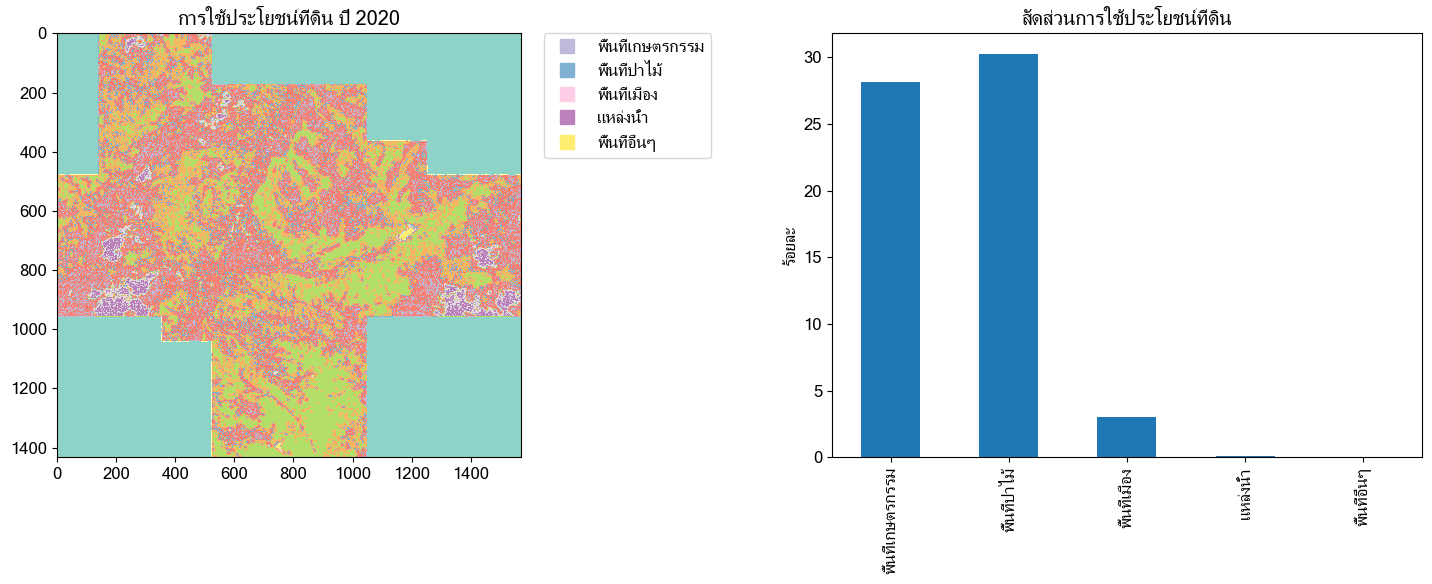

In [2]:
import os
import geopandas as gpd
import numpy as np
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import confusion_matrix

class LandUseAnalysis:
    def __init__(self, shapefile_path):
        self.study_area = gpd.read_file(shapefile_path)
        self.land_use_categories = {
            1: 'พื้นที่เกษตรกรรม',
            2: 'พื้นที่ป่าไม้',
            3: 'พื้นที่เมือง',
            4: 'แหล่งน้ำ',
            5: 'พื้นที่อื่นๆ'
        }
    
    def load_satellite_data(self, raster_path, year):
        with rasterio.open(raster_path) as src:
            self.satellite_data = src.read()
            self.metadata = src.meta
            self.year = year
    
    def classify_land_use(self):
        classified = np.zeros_like(self.satellite_data[0])
        
        # คำนวณ NDVI จากแถบที่ 4 (NIR) และแถบที่ 3 (Red)
        ndvi = (self.satellite_data[3] - self.satellite_data[2]) / (self.satellite_data[3] + self.satellite_data[2])
        
        # กำหนดรหัสการจำแนก
        classified[ndvi > 0.5] = 2          # ป่าไม้
        classified[ndvi < 0] = 4            # แหล่งน้ำ
        classified[(ndvi >= 0) & (ndvi <= 0.2)] = 3  # เมือง
        classified[(ndvi > 0.2) & (ndvi <= 0.5)] = 1  # เกษตรกรรม
        
        self.classified_data = classified
        
        # บันทึกข้อมูลการจำแนกลงไฟล์
        with rasterio.open('classified_data.tif', 'w', **self.metadata) as dst:
            dst.write(classified, 1)
        
        return classified
    
    def calculate_area_statistics(self):
        stats = {}
        # คำนวณพื้นที่ของพิกเซลจาก transform matrix
        pixel_area = abs(self.metadata['transform'][0] * self.metadata['transform'][4])
        
        for code, name in self.land_use_categories.items():
            area = np.sum(self.classified_data == code) * pixel_area
            total_area = self.metadata['width'] * self.metadata['height'] * pixel_area
            percentage = (area / total_area) * 100
            stats[name] = {
                'area_sq_km': area / 1e6,  # แปลงเป็น ตารางกิโลเมตร
                'percentage': percentage
            }
        
        return pd.DataFrame(stats).T
    
    def create_change_matrix(self, old_classification, new_classification):
        matrix = confusion_matrix(old_classification.flatten(), 
                                  new_classification.flatten(),
                                  labels=list(self.land_use_categories.keys()))
        
        df_matrix = pd.DataFrame(matrix,
                                 index=[f'From {v}' for v in self.land_use_categories.values()],
                                 columns=[f'To {v}' for v in self.land_use_categories.values()])
        return df_matrix
    
    def plot_results(self):
        # กำหนด path ของฟอนต์สำหรับภาษาไทย (ตรวจสอบ OS)
        if os.name == 'nt':  # Windows
            font_paths = [
                'c:/Windows/Fonts/THSarabunNew.ttf',
                'c:/Windows/Fonts/Tahoma.ttf',
                'c:/Windows/Fonts/THSarabun.ttf',
                'c:/Windows/Fonts/Angsana.ttf'
            ]
        else:  # MacOS และ Linux
            font_paths = [
                '/usr/share/fonts/thai/THSarabunNew.ttf',
                '/Library/Fonts/THSarabunNew.ttf',
                '/usr/share/fonts/truetype/thai/Sarabun-Regular.ttf'
            ]
        
        font_path = None
        for path in font_paths:
            if os.path.exists(path):
                font_path = path
                break
        
        if font_path:
            font_prop = fm.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = font_prop.get_name()
        else:
            plt.rcParams['font.family'] = 'Microsoft Sans Serif'
        
        plt.rcParams['font.size'] = 12
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # แสดงผลแผนที่การใช้ประโยชน์ที่ดิน
        im = ax1.imshow(self.classified_data, cmap='Set3')
        ax1.set_title(f'การใช้ประโยชน์ที่ดิน ปี {self.year}')
        
        # สร้าง legend
        patches = [plt.plot([], [], marker="s", ms=10, ls="", color=plt.cm.Set3(i/5.), 
                              label=name)[0] 
                   for i, name in self.land_use_categories.items()]
        ax1.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        # กราฟแสดงสัดส่วนการใช้ประโยชน์ที่ดิน
        stats = self.calculate_area_statistics()
        stats['percentage'].plot(kind='bar', ax=ax2)
        ax2.set_title('สัดส่วนการใช้ประโยชน์ที่ดิน')
        ax2.set_ylabel('ร้อยละ')
        
        plt.tight_layout()
        return fig

    def run_analysis(self, raster_path_2010, raster_path_2020):
        # วิเคราะห์ข้อมูลปี 2010
        self.load_satellite_data(raster_path_2010, 2010)
        classification_2010 = self.classify_land_use()
        stats_before = self.calculate_area_statistics()
        
        # เก็บผล classification ของปี 2010 ไว้ก่อนเพื่อเปรียบเทียบ
        classification_2010_copy = classification_2010.copy()
        
        # วิเคราะห์ข้อมูลปี 2020
        self.load_satellite_data(raster_path_2020, 2020)
        classification_2020 = self.classify_land_use()
        stats_after = self.calculate_area_statistics()
        
        # สร้าง matrix เปรียบเทียบการเปลี่ยนแปลง
        change_matrix = self.create_change_matrix(classification_2010_copy, classification_2020)
        
        # สร้างแผนที่และกราฟแสดงผล
        fig = self.plot_results()
        
        return stats_before, stats_after, change_matrix, fig

# ตัวอย่างการใช้งาน
if __name__ == "__main__":
    shapefile_path = os.path.join(os.getcwd(), 'data', 'meatha.shp')
    raster_path_2010 = os.path.join(os.getcwd(), 'sentinel2_data', 'sentinel2_2019_merged.tif')
    raster_path_2020 = os.path.join(os.getcwd(), 'sentinel2_data', 'sentinel2_2022_merged.tif')
    
    analysis = LandUseAnalysis(shapefile_path)
    stats_before, stats_after, change_matrix, fig = analysis.run_analysis(raster_path_2010, raster_path_2020)
    
    print("สถิติการใช้ประโยชน์ที่ดินปี 2010:")
    print(stats_before)
    print("\nสถิติการใช้ประโยชน์ที่ดินปี 2020:")
    print(stats_after)
    print("\nMatrix การเปลี่ยนแปลงการใช้ประโยชน์ที่ดิน:")
    print(change_matrix)
    
    plt.show()


In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

results = model.predict(source='https://ultralytics.com/images/bus.jpg', classes=2)

for i, result in enumerate(results):
    result.save_dir = f"test_{i + 1}"
    result.show()
    print(f"Prediction {i + 1}: {result}")

    # show results 



Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /Users/sakdahomhuan/Dev/lab_154432/bus.jpg: 640x480 (no detections), 72.7ms
Speed: 3.1ms preprocess, 72.7ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 480)
Result saved to test/output_image.jpg


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="coco8.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=640,  # training image size
    device="cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

# Evaluate model performance on the validation set
metrics = model.val()

# Perform object detection on an image
results = model("path/to/image.jpg")
results[0].show()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /Users/sakdahomhuan/Dev/lab_154432/bus.jpg: 640x480 1 bus, 68.5ms
Speed: 1.4ms preprocess, 68.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


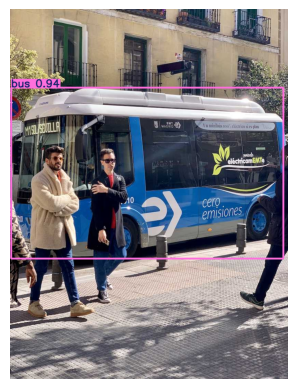

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2 

model = YOLO("yolo11n.pt")

results = model.predict(source="https://ultralytics.com/images/bus.jpg", classes=[5])

for result in results:
    annotated_img = result.plot()
    
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(annotated_img)
    plt.axis("off")  
    plt.show()


In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2  

model = YOLO("yolo11n.pt")
image_folder = "./CarsDetection/test/images" 
results = model.predict(source=image_folder) 
for result in results:
    annotated_img = result.plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    plt.imshow(annotated_img)
    plt.axis("off")  # Hide axes
    plt.title(f"Image: {result.path}") 
    plt.show()
